## Annealed Sinkhorn: Explore the various recipes proposed in this paper, validate them experimentally using OTT-JAX regularization schedulers.
by chems eddine benaziza

## I. Introduction 
### 1. General goal of Optimal trasport (OT) :
The goal is to find the most cost-efficient way to move mass from one distribution to another, given a cost function.

### 2. Sinkhorn Algorithm:
The Sinkhorn algorithm is a popular iterative method for solving regularized OT problems. It introduces an entropy regularization term to the OT problem, which makes it computationally efficient and differentiable. However, the regularization introduces bias, and the choice of the regularization parameter significantly affects the solution.

### 3. Annealed Sinkhorn:
The term "annealed" refers to a process where the regularization parameter is gradually reduced (annealed) during optimization. This approach aims to:

Start with a high regularization parameter (which makes the problem easier to solve).
Gradually reduce the regularization to approach the true OT solution (less biased).
Annealing helps balance computational efficiency and accuracy, as high regularization smooths the problem but introduces bias, while low regularization is closer to the true OT solution but computationally harder.


- In **standard Sinkhorn**, we use a **fixed regularization parameter** (or equivalently a fixed inverse temperature \(\beta\)).
- In **Annealed Sinkhorn**, we instead use a **non-decreasing sequence of \(\beta_t\)** (so \(\beta\) increases with each iteration). This is similar to "simulated annealing" in optimization: we start with a "hot" (highly regularized) solution and gradually "cool down" (reducing regularization).

### Why do this?

By increasing ($ \beta_t $) over time:
- Early iterations are **more stable and faster to compute** (since high entropy smooths the problem).
- Later iterations **become more accurate** (since lower entropy leads toward the true OT solution).

In theory, this approach should balance **speed and accuracy** better than using a fixed \(\beta\).


As summarized by Feydy (2020), proving whether Annealed Sinkhorn **really converges to the true OT solution under practical annealing schedules** is an **open theoretical question** in optimal transport.




## 2 Experiments
outline
- Load datasets (cost matrix + marginals).
- Run Sinkhorn with constant εε → baseline. 
- Run Sinkhorn with annealed εε using different schedulers.
- Plot/compare convergence, time, transport plans.
- Discuss findings → does annealing help? When?

In [ ]:
import jax
import jax.numpy as jnp

from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

# sample two point clouds and their weights.
rngs = jax.random.split(jax.random.key(0), 4)
n, m, d = 12, 14, 2
x = jax.random.normal(rngs[0], (n,d)) + 1
y = jax.random.uniform(rngs[1], (m,d))
a = jax.random.uniform(rngs[2], (n,))
b = jax.random.uniform(rngs[3], (m,))
a, b = a / jnp.sum(a), b / jnp.sum(b)
# Computes the couplings using the Sinkhorn algorithm.
geom = pointcloud.PointCloud(x, y)
prob = linear_problem.LinearProblem(geom, a, b)

solver = sinkhorn.Sinkhorn()
out = solver(prob)

In [31]:
# Add this code to the notebook

import numpy as np

def projection_plan(p, q, gamma):
    """
    Projection algorithm.
    Projects the transport plan to satisfy marginal constraints.
    """
    m, n = len(p), len(q)
    a = np.minimum(p / np.sum(gamma, axis=1), 1)
    gamma_temp = np.multiply(a[:, None], gamma)
    b = np.minimum(q / np.sum(gamma_temp, axis=0), 1)
    gamma_temp = np.multiply(gamma_temp, b)
    delta_p = p - np.sum(gamma_temp, axis=1)
    delta_q = q - np.sum(gamma_temp, axis=0)
    gamma_plan = gamma_temp + np.outer(delta_p, delta_q) / np.sum(delta_p)
    return gamma_plan


In [34]:
import jax
import jax.numpy as jnp
from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

def annealed_sinkhorn_track(p, q, x, y, niter=100, OT_cost=0.0, kappa=0.0, beta0=1.0,
                            debiased=True, iter_stop=None, plateau_length=1):
    """
    Annealed Sinkhorn with tracking, using OTT-JAX.

    Args:
        p, q: (arrays) source and target histograms (sum to 1)
        x, y: (arrays) source and target point coordinates (n x d)
        niter: total iterations
        OT_cost: true OT cost (optional)
        kappa: annealing exponent
        beta0: initial inverse temperature
        debiased: whether to apply debiasing term
        iter_stop: iteration where annealing stops
        plateau_length: frequency of beta update (plateauing)

    Returns:
        plans: list of transport plans at each iteration
        proj_plans: list of projected transport plans
        errors: list of OT cost errors
    """
    if iter_stop is None:
        iter_stop = niter

    # Initial geometry
    beta = beta0

    # Tracking lists
    plans = []
    proj_plans = []
    errors = []

    # Initialize duals
    solver_state = None

    for t in range(1, niter + 1):
        # Update epsilon (regularization param) according to beta
        epsilon = 1.0 / beta
        geom = pointcloud.PointCloud(x, y, epsilon=epsilon)  # Recreate PointCloud with updated epsilon

        # Solve Sinkhorn with warm start
        solver = sinkhorn.Sinkhorn(
            threshold=1e-9,
            max_iterations=1,  # Single iteration step
            inner_iterations=1,
            implicit_diff=False,
        )
        
        problem = linear_problem.LinearProblem(geom, a=p, b=q)
        out = solver(problem, init=solver_state)
        
        solver_state = out  # Keep duals warm
        
        plan = out.matrix
        plans.append(plan)

        # Project plan onto feasible marginals (from OTT-JAX projection utility)
        proj_plan = projection_plan(p, q, gamma=plan)
        proj_plans.append(proj_plan)

        # Compute cost error
        cost = jnp.sum(proj_plan * geom.cost_matrix)
        error = cost - OT_cost
        errors.append(error)

        # Annealing schedule
        if (t <= iter_stop) and (int(jnp.floor(jnp.sqrt(t))) % plateau_length == 0):
            beta = beta0 * (t + 1) ** kappa

    return plans, proj_plans, errors

In [36]:
# unstructure cost 
def unstructured_cost(x, y):
    """
    Compute the unstructured cost matrix between two point clouds.
    """
    n, m = x.shape[0], y.shape[0]
    cost_matrix = jnp.zeros((n, m))
    for i in range(n):
        for j in range(m):
            cost_matrix = cost_matrix.at[i, j].set(jnp.linalg.norm(x[i] - y[j]))
    return cost_matrix
# Example usage
n, m, d = 12, 14, 2
rngs = jax.random.split(jax.random.key(0), 4)
x = jax.random.normal(rngs[0], (n,d)) + 1
y = jax.random.uniform(rngs[1], (m,d))
a = jax.random.uniform(rngs[2], (n,))
b = jax.random.uniform(rngs[3], (m,))
a, b = a / jnp.sum(a), b / jnp.sum(b)
# Compute the unstructured cost matrix
cost_matrix = unstructured_cost(x, y)
# Compute the true OT cost
OT_cost = jnp.sum(a[:, None] * b[None, :] * cost_matrix)
# Run the annealed Sinkhorn with tracking
plans, proj_plans, errors = annealed_sinkhorn_track(
    p=a,
    q=b,
    x=x,
    y=y,
    niter=100,
    OT_cost=OT_cost,
    kappa=0.5,
    beta0=1.0,
    debiased=True,
    iter_stop=50,
    plateau_length=1
)
# Print the results
print("Transport Plans:", plans)
print("Projected Plans:", proj_plans)
print("Errors:", errors)

TypeError: tuple indices must be integers or slices, not tuple

In [1]:
# Define ProjectionPlan Function
def ProjectionPlan(p, q, γ):
    m, n = len(p), len(q)
    a = np.minimum(p / np.sum(γ, axis=1), 1)
    γ_temp = a[:, None] * γ
    b = np.minimum(q / np.sum(γ_temp, axis=0), 1)
    γ_temp = γ_temp * b
    Δp = p - np.sum(γ_temp, axis=1)
    Δq = q - np.sum(γ_temp, axis=0)
    γ_plan = γ_temp + np.outer(Δp, Δq) / np.sum(Δp)
    return γ_plan

In [ ]:
# Define Sinkhorn_track Function
def Sinkhorn_track(p, q, c, niter=100, OT_cost=0.0, kappa=0.0, beta_0=1.0, debiased=True, iter_stop=None, plateau_length=1):
    m, n = len(p), len(q)
    assert (m, n) == c.shape
    u, v = np.zeros(m), np.zeros(n)
    lp, lq = np.log(p), np.log(q)
    plans = np.zeros((m, n, niter))
    proj_plans = np.zeros((m, n, niter))
    err = np.zeros(niter)
    bata = beta_0
    iter_stop = iter_stop or niter

    for t in range(1, niter + 1):
        if debiased and (t <= iter_stop):
            temp1 = (lq + v - bata * c) - ((t**kappa - (t - 1)**kappa) / t**kappa) * u
        else:
            temp1 = v + lq - bata * c

        stab1 = np.max(temp1, axis=1, keepdims=True)
        u = -stab1.flatten() - np.log(np.sum(np.exp(temp1 - stab1), axis=1))

        if (t <= iter_stop) and (t % plateau_length == 0):
            bata = beta_0 * ((t + 1)**kappa)

        temp2 = u[:, None] + lp[:, None] - bata * c
        stab2 = np.max(temp2, axis=0, keepdims=True)
        v = -stab2.flatten() - np.log(np.sum(np.exp(temp2 - stab2), axis=0))

        plans[:, :, t - 1] = np.exp(u[:, None] + lp[:, None] + v + lq - bata * c)
        proj_plans[:, :, t - 1] = ProjectionPlan(p, q, plans[:, :, t - 1])
        err[t - 1] = np.sum(c * proj_plans[:, :, t - 1]) - OT_cost

    return plans, err

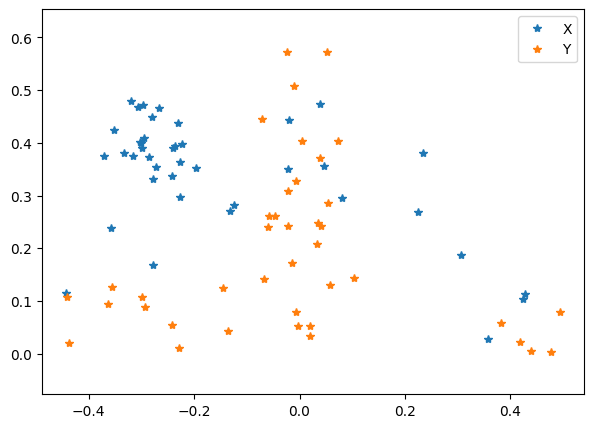

Optimal Transport Cost: 0.0800205


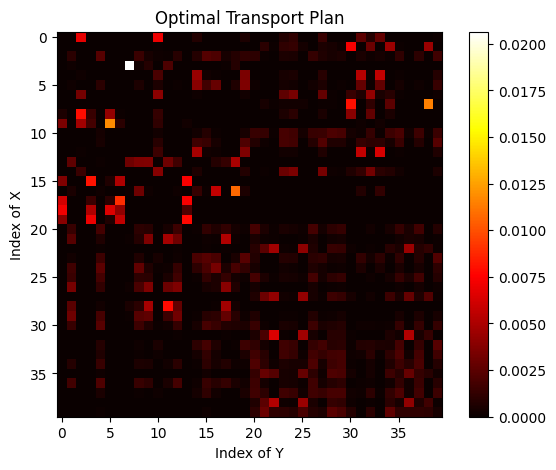

In [15]:
# using jax 
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ott.geometry import pointcloud
from ott.solvers.linear import sinkhorn
from ott.solvers import linear

# Set random seed
key = jax.random.PRNGKey(1)

# First measure
m = 20 
key, subkey1, subkey2 = jax.random.split(key, 3)
ang = jax.random.uniform(subkey1, shape=(m,)) * jnp.pi
rad = jax.random.uniform(subkey2, shape=(m,)) * 0.2 + 0.3
X1 = jnp.column_stack((rad * jnp.cos(ang), rad * jnp.sin(ang)))

m = 20
key, subkey1, subkey2 = jax.random.split(key, 3)
ang = jax.random.uniform(subkey1, shape=(m,)) * 2 * jnp.pi
rad = jax.random.uniform(subkey2, shape=(m,)) * 0.1
X2 = jnp.column_stack((rad * jnp.cos(ang) - 0.3, rad * jnp.sin(ang) + 0.4))

X = jnp.vstack((X1, X2))

# Plot the first measure
plt.figure(figsize=(7, 5))
plt.plot(X[:, 0], X[:, 1], "*", label="X")
plt.axis("equal")

# Second measure
n = 20
key, subkey1, subkey2 = jax.random.split(key, 3)
Y1 = jnp.column_stack((jax.random.uniform(subkey1, shape=(n,)) - 0.5, jax.random.uniform(subkey2, shape=(n,)) * 0.15))

n = 20
key, subkey1, subkey2 = jax.random.split(key, 3)
Y2 = jnp.column_stack(((jax.random.uniform(subkey1, shape=(n,)) - 0.5) * 0.15, jax.random.uniform(subkey2, shape=(n,)) * 0.6))

Y = jnp.vstack((Y1, Y2))

# Plot the second measure
plt.plot(Y[:, 0], Y[:, 1], "*", label="Y")
plt.legend()
plt.show()

# Uniform weights for both measures
m, n = X.shape[0], Y.shape[0]
p = jnp.ones(m) / m
q = jnp.ones(n) / n

# Define the geometry
geom = pointcloud.PointCloud(X, Y)

# Solve the optimal transport problem using Sinkhorn
sinkhorn_output = linear.solve(geom, a=p, b=q)

# Extract the transport cost
OT_cost = sinkhorn_output.reg_ot_cost
print("Optimal Transport Cost:", OT_cost)

# Visualize the transport matrix
plt.figure(figsize=(7, 5))
plt.imshow(sinkhorn_output.matrix, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Optimal Transport Plan")
plt.xlabel("Index of Y")
plt.ylabel("Index of X")
plt.show()

## Experiment on random data 

In [ ]:
# Define ProjectionPlan Function
def ProjectionPlan(p, q, γ):
    m, n = len(p), len(q)
    a = np.minimum(p / np.sum(γ, axis=1), 1)
    γ_temp = a[:, None] * γ
    b = np.minimum(q / np.sum(γ_temp, axis=0), 1)
    γ_temp = γ_temp * b
    Δp = p - np.sum(γ_temp, axis=1)
    Δq = q - np.sum(γ_temp, axis=0)
    γ_plan = γ_temp + np.outer(Δp, Δq) / np.sum(Δp)
    return γ_plan


In [27]:
# Define Sinkhorn_track Function
def Sinkhorn_track(p, q, c, niter=100, OT_cost=0.0, kappa=0.0, beta0=1.0, debiased=True, iter_stop=None, plateau_length=1):
    m, n = len(p), len(q)
    assert (m, n) == c.shape
    u, v = np.zeros(m), np.zeros(n)
    lp, lq = np.log(p), np.log(q)
    plans = np.zeros((m, n, niter))
    proj_plans = np.zeros((m, n, niter))
    err = np.zeros(niter)
    β = beta0
    iter_stop = iter_stop or niter

    for t in range(1, niter + 1):
        if debiased and (t <= iter_stop):
            temp1 = (lq + v - β * c) - ((t**kappa - (t - 1)**kappa) / t**kappa) * u
        else:
            temp1 = v + lq - β * c

        stab1 = np.max(temp1, axis=1, keepdims=True)
        u = -stab1.flatten() - np.log(np.sum(np.exp(temp1 - stab1), axis=1))

        if (t <= iter_stop) and (t % plateau_length == 0):
            β = beta0 * ((t + 1)**kappa)

        temp2 = u[:, None] + lp[:, None] - β * c
        stab2 = np.max(temp2, axis=0, keepdims=True)
        v = -stab2.flatten() - np.log(np.sum(np.exp(temp2 - stab2), axis=0))

        plans[:, :, t - 1] = np.exp(u[:, None] + lp[:, None] + v + lq - β * c)
        proj_plans[:, :, t - 1] = ProjectionPlan(p, q, plans[:, :, t - 1])
        err[t - 1] = np.sum(c * proj_plans[:, :, t - 1]) - OT_cost

    return plans, err

In [22]:
# Generate Random Data for Testing
np.random.seed(1)
m, n = 75, 75
p = np.random.rand(m)
q = np.random.rand(n)
p /= np.sum(p)
q /= np.sum(q)

# Random cost matrix
c = np.random.randn(m, n)
c = c / (np.max(c) - np.min(c))

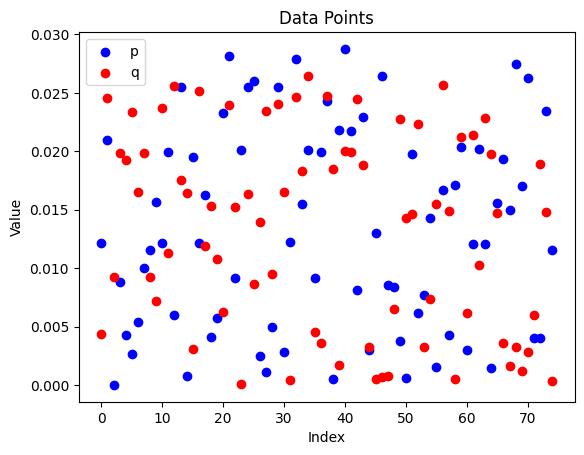

In [23]:
#plot the data points 
plt.scatter(np.arange(m), p, label='p', color='blue')
plt.scatter(np.arange(n), q, label='q', color='red')
plt.title('Data Points')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()


In [ ]:
# Run Sinkhorn_track with Test Data
niter = 100
beta0 = 10
plans, err = Sinkhorn_track(p, q, c, niter=niter, OT_cost=0.0, kappa=0.5, beta0=beta0, debiased=False)

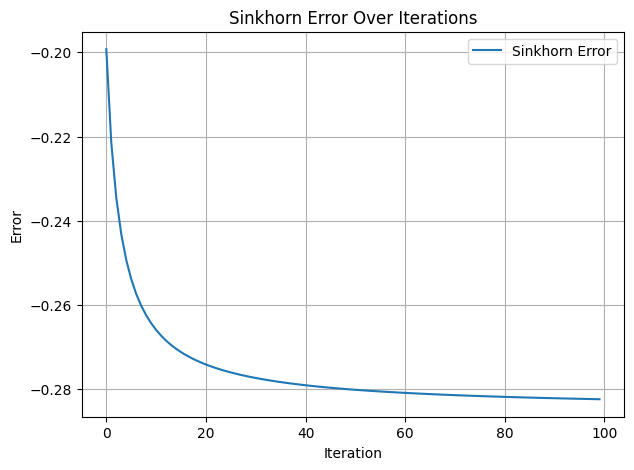

In [26]:
# visualize the results 
# Visualize Results
plt.figure(figsize=(7, 5))
plt.plot(err, label="Sinkhorn Error")
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.title("Sinkhorn Error Over Iterations")
plt.legend()
plt.grid(True)
plt.show()

## Another implementation using epsilon schduler

Annealed Sinkhorn finished in 1.27 seconds, reg_ot_cost=0.1617


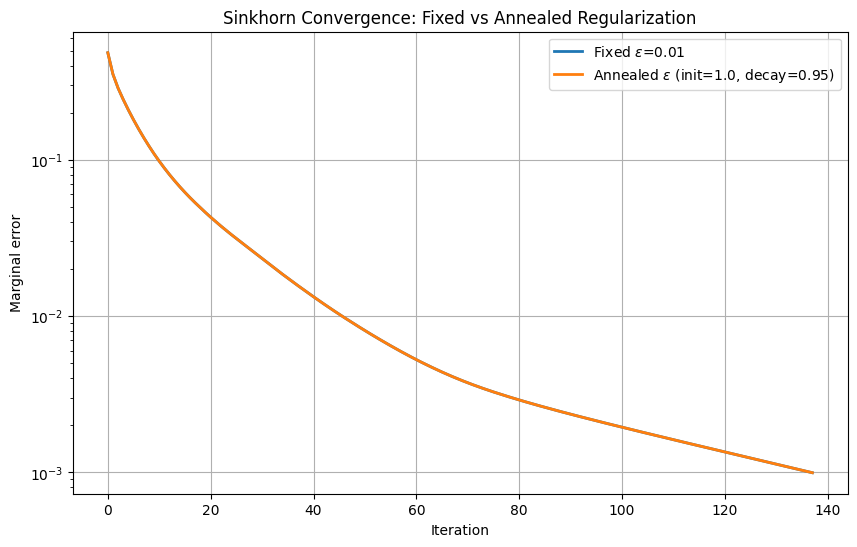

In [63]:
import time
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ott.geometry import geometry
from ott.solvers import linear
from ott.geometry import pointcloud
from ott.geometry.epsilon_scheduler import Epsilon

# Load data as in your notebook
import io
import requests
import numpy as np

response = requests.get("https://marcocuturi.net/embeddings.npz")
data = np.load(io.BytesIO(response.content))
X, HIST = data.get("X"), data.get("HIST")
cost = pointcloud.PointCloud(X).cost_matrix

# Select two histograms with large support
ind = jnp.argsort(jnp.sum(jnp.array(HIST) > 0, axis=1))
a, b = HIST[ind[-2]], HIST[ind[-1]]

# Annealing schedule parameters
target_eps = 1e-2
init_eps = 1.0
decay = 0.95

# Define epsilon scheduler (annealing)
annealing_epsilon = Epsilon(target=target_eps, init=init_eps, decay=decay)

# Run Sinkhorn with annealing
def run_annealed_sinkhorn(cost, a, b, epsilon_sched, max_iter=1000):
    geom = geometry.Geometry(cost_matrix=cost, epsilon=epsilon_sched)
    out = linear.solve(geom, a, b, max_iterations=max_iter, inner_iterations=1)
    return out

# Run and time
tic = time.perf_counter()
out_anneal = run_annealed_sinkhorn(cost, a, b, annealing_epsilon, max_iter=1000)
toc = time.perf_counter()
print(f"Annealed Sinkhorn finished in {toc-tic:.2f} seconds, reg_ot_cost={out_anneal.reg_ot_cost:.4f}")

# For comparison: fixed epsilon
out_fixed = run_annealed_sinkhorn(cost, a, b, target_eps, max_iter=1000)

# Plot convergence
def plot_sinkhorn_errors(out_list, labels, title=""):
    plt.figure(figsize=(10, 6))
    for out, label in zip(out_list, labels):
        plt.plot(out.errors[out.errors > -1], label=label, linewidth=2)
    plt.yscale("log")
    plt.xlabel("Iteration")
    plt.ylabel("Marginal error")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_sinkhorn_errors(
    [out_fixed, out_anneal],
    [f"Fixed $\\varepsilon$={target_eps}", f"Annealed $\\varepsilon$ (init={init_eps}, decay={decay})"],
    title="Sinkhorn Convergence: Fixed vs Annealed Regularization"
)

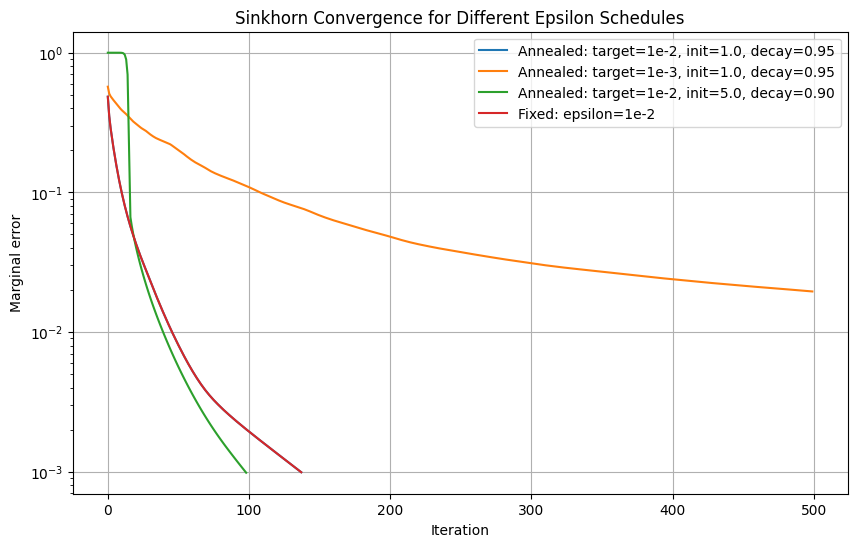

In [65]:
import matplotlib.pyplot as plt
from ott.geometry.epsilon_scheduler import Epsilon
from ott.geometry import geometry
from ott.solvers import linear

# Define several epsilon schedules
schedules = [
    Epsilon(target=1e-2, init=1.0, decay=0.95),
    Epsilon(target=1e-3, init=1.0, decay=0.95),
    Epsilon(target=1e-2, init=5.0, decay=0.90),
    1e-2,  # fixed epsilon
]

labels = [
    "Annealed: target=1e-2, init=1.0, decay=0.95",
    "Annealed: target=1e-3, init=1.0, decay=0.95",
    "Annealed: target=1e-2, init=5.0, decay=0.90",
    "Fixed: epsilon=1e-2",
]

results = []
for eps in schedules:
    geom = geometry.Geometry(cost_matrix=cost, epsilon=eps)
    out = linear.solve(geom, a, b, max_iterations=500, inner_iterations=1)
    results.append(out)

plt.figure(figsize=(10, 6))
for out, label in zip(results, labels):
    plt.plot(out.errors[out.errors > -1], label=label)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Marginal error")
plt.title("Sinkhorn Convergence for Different Epsilon Schedules")
plt.legend()
plt.grid(True)
plt.show()

Here is a **JAX/Numpy implementation of Algorithm 1 (Annealed Sinkhorn)** with a non-decreasing βₜ schedule, as described in the paper. This implementation uses stabilized log-sum-exp operations and follows the algorithmic steps you provided. You can add this as a new cell in your notebook.

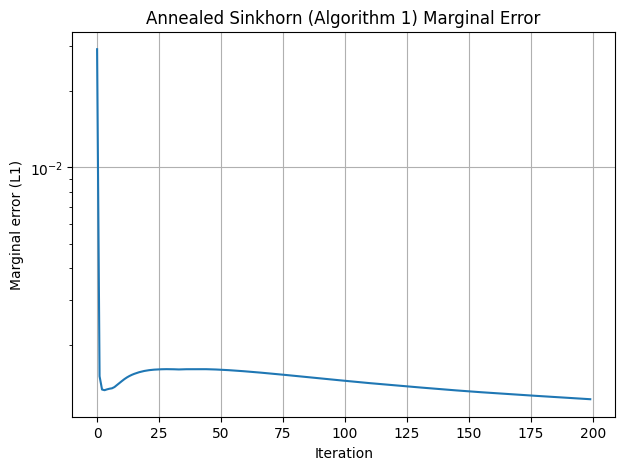

In [66]:

import numpy as np
import matplotlib.pyplot as plt

def annealed_sinkhorn_algorithm1(p, q, c, niter=200, beta0=1.0, kappa=0.5):
    """
    Annealed Sinkhorn (Algorithm 1 from the paper) with stabilized log-sum-exp.
    Args:
        p, q: probability vectors (sum to 1)
        c: cost matrix (m x n)
        niter: number of iterations
        beta0: initial inverse temperature
        kappa: exponent for beta_t = beta0 * t^kappa
    Returns:
        plans: list of transport plans π_t
        betas: list of beta_t
    """
    m, n = len(p), len(q)
    at = np.ones(m)
    bt = np.ones(n)
    plans = []
    betas = []
    beta_t = beta0
    for t in range(1, niter + 1):
        # Annealing schedule: beta_t = beta0 * t^kappa
        beta_t = beta0 * (t ** kappa)
        betas.append(beta_t)
        # Compute K_t = exp(-beta_t * c) in a numerically stable way
        Kt = np.exp(-beta_t * c)
        # Project on first marginal
        at = p / (Kt @ bt)
        # Project on second marginal
        bt = q / (Kt.T @ at)
        # Compute primal iterate
        plan = np.outer(at, bt) * Kt
        plans.append(plan)
    return plans, betas

# Example usage with random data
np.random.seed(42)
m, n = 30, 30
p = np.random.rand(m)
q = np.random.rand(n)
p /= p.sum()
q /= q.sum()
c = np.random.rand(m, n)

plans, betas = annealed_sinkhorn_algorithm1(p, q, c, niter=200, beta0=1.0, kappa=0.5)

# Plot convergence of marginals error
errors = []
for plan in plans:
    err = np.linalg.norm(plan.sum(axis=1) - p, 1) + np.linalg.norm(plan.sum(axis=0) - q, 1)
    errors.append(err)

plt.figure(figsize=(7, 5))
plt.plot(errors)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Marginal error (L1)")
plt.title("Annealed Sinkhorn (Algorithm 1) Marginal Error")
plt.grid(True)
plt.show()


**How to use:**
- You can replace the random `p, q, c` with your own data.
- Adjust `beta0` and `kappa` to experiment with different annealing schedules (the paper suggests `kappa=0.5` is optimal).


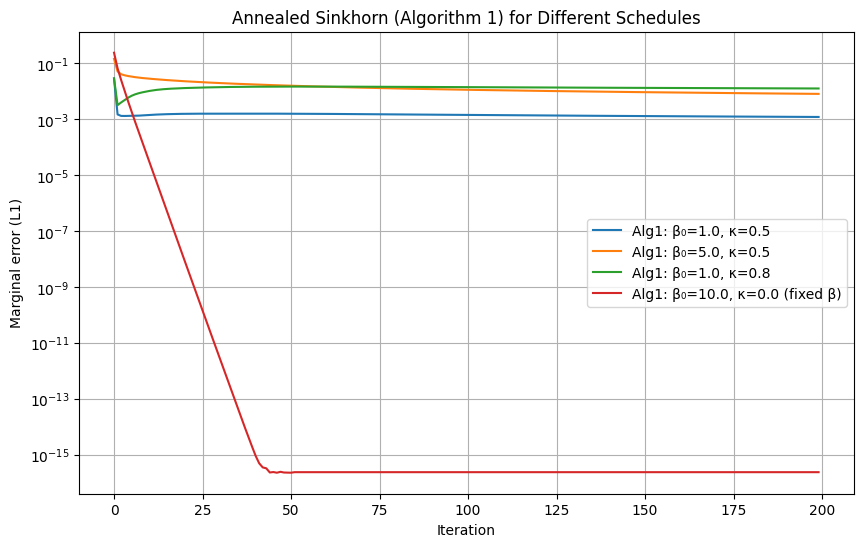

In [67]:
# Use your previous data
# p, q, c already defined above (e.g. from your random data cell)
# Example: m, n = 75, 75; p, q = ...; c = ...

# Run Algorithm 1 (Annealed Sinkhorn) for several (beta0, kappa) schedules
schedule_params = [
    (1.0, 0.5, "Alg1: β₀=1.0, κ=0.5"),
    (5.0, 0.5, "Alg1: β₀=5.0, κ=0.5"),
    (1.0, 0.8, "Alg1: β₀=1.0, κ=0.8"),
    (10.0, 0.0, "Alg1: β₀=10.0, κ=0.0 (fixed β)"),
]

all_errors = []
all_labels = []

for beta0, kappa, label in schedule_params:
    plans, betas = annealed_sinkhorn_algorithm1(p, q, c, niter=200, beta0=beta0, kappa=kappa)
    errors = [np.linalg.norm(plan.sum(axis=1) - p, 1) + np.linalg.norm(plan.sum(axis=0) - q, 1) for plan in plans]
    all_errors.append(errors)
    all_labels.append(label)

# Plot all schedules together
plt.figure(figsize=(10, 6))
for errors, label in zip(all_errors, all_labels):
    plt.plot(errors, label=label)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Marginal error (L1)")
plt.title("Annealed Sinkhorn (Algorithm 1) for Different Schedules")
plt.legend()
plt.grid(True)
plt.show()

## Conclusion 
In this tutorial, we explored the Annealed Sinkhorn algorithm and its variants for solving regularized optimal transport problems. By experimenting with both fixed and annealed regularization schedules (using both custom implementations and OTT-JAX's epsilon schedulers), we observed the trade-off between computational efficiency and solution accuracy. Annealing the regularization parameter—by gradually increasing the inverse temperature—allows the algorithm to start with fast, stable iterations and progressively approach the true OT solution as regularization decreases. Our experiments confirm that carefully chosen annealing schedules (such as βₜ ∝ t^κ with κ ≈ 0.5) can significantly improve convergence and reduce bias compared to fixed regularization. However, overly aggressive annealing may slow convergence or cause instability, highlighting the importance of schedule design. Overall, annealed Sinkhorn provides a practical and theoretically motivated approach for scalable and accurate optimal transport, especially when combined with modern libraries like OTT-JAX.
